<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-research-datasets/scin/blob/main/scin_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-research-datasets/scin/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## SCIN dataset demo

This colab demos how to load the SCIN dataset from the CSV files in Google Cloud Storage.


## Setup

In [ ]:
#@title Install the required packages

!pip install matplotlib google-cloud-storage

In [ ]:
#@title Imports

import collections
import copy
import hashlib
import io
import os
import subprocess
import textwrap
import time

from typing import List, Text

from PIL import Image

import numpy as np
import pandas as pd
import tabulate


import tensorflow as tf

import matplotlib.pyplot as plt


### Authenticate


The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [ ]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

### Configuration

In [ ]:
#@title Global params

class Globals:
  # GCP project with GCS bucket of interest
  gcp_project = 'dx-scin-public' #@param

  # GCS bucket with data to read
  gcs_bucket_name = 'dx-scin-public-data' #@param

  # CSV of case metadata to read
  cases_csv = 'dataset/scin_cases.csv' #@param

  # CSV of label metadata to read
  labels_csv = 'dataset/scin_labels.csv' #@param

  # Images directory
  gcs_images_dir = 'dataset/images/' #@param

  ### Key column names
  image_path_columns = ['image_1_path', 'image_2_path', 'image_3_path']
  weighted_skin_condition_label = "weighted_skin_condition_label"
  skin_condition_label = "dermatologist_skin_condition_on_label_name"

  ###### Formed during execution:

  # Client for querying GCS
  gcs_storage_client = None

  # Bucket object for loading files
  gcs_bucket = None

  # pd.DataFrame for the loaded metadata_csv
  cases_df = None

  # pd.DataFrame for the loaded labels_csv
  cases_and_labels_df = None

print(f'GCS bucket name: {Globals.gcs_bucket_name}')
print(f'cases_csv: {Globals.cases_csv}')
print(f'labels_csv: {Globals.labels_csv}')
print(f'images dir: {Globals.gcs_images_dir}')




GCS bucket name: dx-scin-public-data
cases_csv: dataset/scin_cases.csv
labels_csv: dataset/scin_labels.csv
images dir: dataset/images/


## Load dataset

In [ ]:
#@title Create a dataframe that contains the metadata and condition labels

from google.cloud import storage

def list_blobs(storage_client, bucket_name):
  """Helper to list blobs in a bucket (useful for debugging)."""
  blobs = storage_client.list_blobs(bucket_name)
  for blob in blobs:
    print(blob)

def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

Globals.gcs_storage_client = storage.Client(Globals.gcp_project)
Globals.gcs_bucket = Globals.gcs_storage_client.bucket(
    Globals.gcs_bucket_name
)
Globals.cases_df = initialize_df_with_metadata(Globals.gcs_bucket, Globals.cases_csv)
Globals.cases_and_labels_df = augment_metadata_with_labels(Globals.cases_df, Globals.gcs_bucket, Globals.labels_csv)
print(len(Globals.cases_and_labels_df))

5033


In [ ]:
Globals.cases_and_labels_df.columns

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

In [ ]:
Globals.cases_and_labels_df.sample(1)

,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
926,-4118522682722481510,SCIN,1.0.0,2023,AGE_50_TO_59,FEMALE,FST1,NaN,NaN,NaN,...,YES,NO,YES,FST2,NaN,FST2,True,True,2.0,3.0


In [ ]:
Globals.cases_and_labels_df

,case_id,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
0,-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
1,-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
2,-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
3,-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
4,-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,973759811984683137,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST3,NaN,NaN,NaN,...,YES,YES,YES,FST2,FST2,FST3,True,True,4.0,4.0
5029,973872028150293734,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,1.0
5030,983265958160210646,SCIN,1.0.0,2023,AGE_18_TO_29,FEMALE,FST5,NaN,NaN,YES,...,YES,NaN,NaN,FST5,NaN,NaN,True,True,4.0,5.0
5031,995820220956352730,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,FST5,NaN,NaN,NaN,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,2.0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('age_group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('sex_at_birth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('fitzpatrick_skin_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('race_ethnicity_american_indian_or_alaska_native').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('age_group')):
  _plot_series(series, series_name, i)
  fig.legend(title='age_group', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sex_at_birth')):
  _plot_series(series, series_name, i)
  fig.legend(title='sex_at_birth', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('fitzpatrick_skin_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='fitzpatrick_skin_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('race_ethnicity_american_indian_or_alaska_native')):
  _plot_series(series, series_name, i)
  fig.legend(title='race_ethnicity_american_indian_or_alaska_native', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sex_at_birth'].value_counts()
    for x_label, grp in _df_10.groupby('age_group')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('age_group')
_ = plt.ylabel('sex_at_birth')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['fitzpatrick_skin_type'].value_counts()
    for x_label, grp in _df_11.groupby('sex_at_birth')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('sex_at_birth')
_ = plt.ylabel('fitzpatrick_skin_type')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race_ethnicity_american_indian_or_alaska_native'].value_counts()
    for x_label, grp in _df_12.groupby('fitzpatrick_skin_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('fitzpatrick_skin_type')
_ = plt.ylabel('race_ethnicity_american_indian_or_alaska_native')

ValueError: zero-size array to reduction operation fmin which has no identity

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race_ethnicity_asian'].value_counts()
    for x_label, grp in _df_13.groupby('race_ethnicity_american_indian_or_alaska_native')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('race_ethnicity_american_indian_or_alaska_native')
_ = plt.ylabel('race_ethnicity_asian')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['age_group'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='index', y='age_group', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['sex_at_birth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='sex_at_birth', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['fitzpatrick_skin_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='fitzpatrick_skin_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['race_ethnicity_american_indian_or_alaska_native'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='race_ethnicity_american_indian_or_alaska_native', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

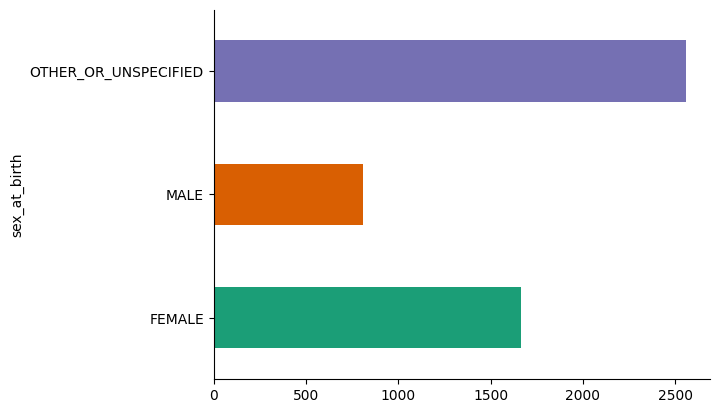

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('sex_at_birth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

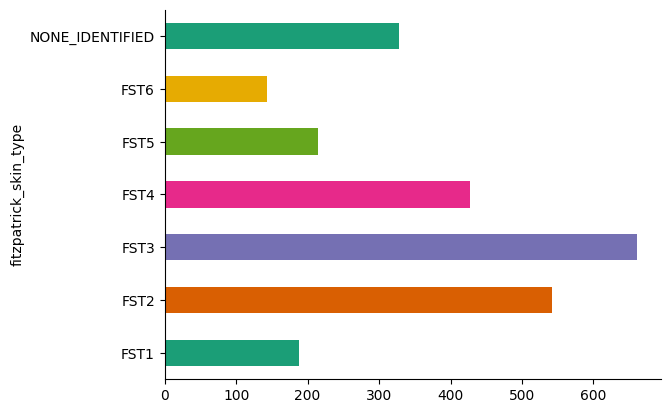

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('fitzpatrick_skin_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

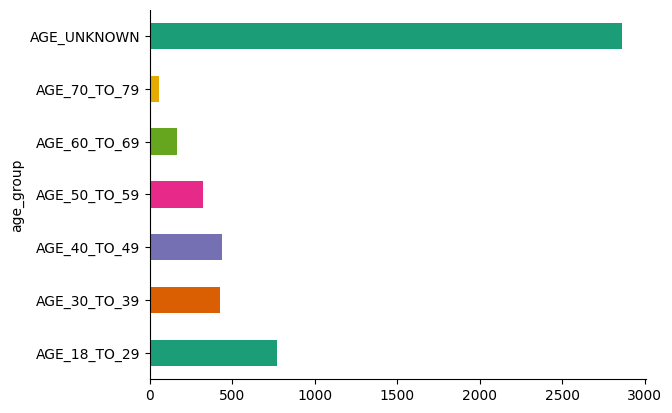

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('age_group').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Get familiar with the data

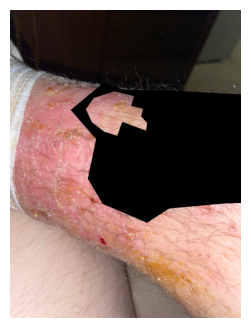

In [ ]:
#@title Display the images for a case (and condition labels, optionally)
import random

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def display_image(bucket, image_path):
  image = Image.open(io.BytesIO(bucket.blob(image_path).download_as_string()))
  figure_size=4
  f, axarr = plt.subplots(1, 1, figsize = (figure_size, figure_size))
  axarr.imshow(image, cmap='gray')
  axarr.axis('off')
  plt.show()

def display_images_for_case(df, case_id="", print_condition_labels=True):
  # Use a random case if none is provided:
  if case_id:
    matched_df = df[df['case_id'] == case_id]
  else:
    matched_df = df.sample(1)

  image_paths = matched_df[Globals.image_path_columns].values.tolist()[0]
  for path in image_paths:
    if isinstance(path, str):
      display_image(Globals.gcs_bucket, path)
  if print_condition_labels:
    condition_labels = matched_df[[Globals.weighted_skin_condition_label]].values.tolist()[0]
    for label in condition_labels:
      if isinstance(label, str):
        print(label)

# display_images_for_case(Globals.cases_and_labels_df, "-1000600354148496558")
display_images_for_case(Globals.cases_and_labels_df)


In [ ]:
#@title Print metadata stats
def print_metadata_stats(df: pd.DataFrame) -> None:
  print(f'Num cases: {len(df)}')

  # Number of cases with 1, 2, or 3 images
  image_1_cnt = df["image_1_path"].count()
  image_2_cnt = df["image_2_path"].count()
  image_3_cnt = df["image_3_path"].count()
  print(f'Num cases with image_1_path set: {image_1_cnt}')
  print(f'Num cases with image_2_path set: {image_2_cnt}')
  print(f'Num cases with image_3_path set: {image_3_cnt}')
  print(f'Total images: {image_1_cnt + image_2_cnt + image_3_cnt}')

  # Sex at birth:
  print('\nSelf-reported Sex at Birth:')
  sab = collections.Counter(df['sex_at_birth'].dropna())
  total = sum(sab.values())
  for k in sorted(sab):
    print(f'  {k} {sab[k]} ({100.0*sab[k]/total:.1f}%)')

  # FST distribution:
  print('\nSelf-reported Fitzpatrick Skin Type:')
  fst = collections.Counter(df['fitzpatrick_skin_type'].dropna())
  total = sum(fst.values())
  for k in sorted(fst):
    print(f'  {k} {fst[k]} ({100.0*fst[k]/total:.1f}%)')


print_metadata_stats(Globals.cases_and_labels_df)

{'Infected eczema': 0.41, 'Stasis Dermatitis': 0.41, 'Cellulitis': 0.18}
Num cases: 5033
Num cases with image_1_path set: 5033
Num cases with image_2_path set: 3085
Num cases with image_3_path set: 2289
Total images: 10407

Self-reported Sex at Birth:
  FEMALE 1666 (33.1%)
  MALE 807 (16.0%)
  OTHER_OR_UNSPECIFIED 2559 (50.9%)

Self-reported Fitzpatrick Skin Type:
  FST1 188 (7.5%)
  FST2 542 (21.7%)
  FST3 661 (26.4%)
  FST4 427 (17.1%)
  FST5 214 (8.5%)
  FST6 143 (5.7%)
  NONE_IDENTIFIED 328 (13.1%)


In [ ]:
#@title Add combined_race_ethnicity column

def merge_race_ethnicity_columns(row):
  combined = []
  for col in row.keys():
    if col.startswith("race_ethnicity_") and row[col] == 'YES':
      combined.append(col[len("race_ethnicity_"):])
  return ",".join(combined)

Globals.cases_and_labels_df["combined_race_ethnicity"] = Globals.cases_and_labels_df.apply(merge_race_ethnicity_columns, axis=1)
Globals.cases_and_labels_df[["case_id", "combined_race_ethnicity"]]

,case_id,combined_race_ethnicity
0,-1000600354148496558,
1,-1002039107727665188,
2,-1003358831658393077,hispanic_latino_or_spanish_origin
3,-1003826561155964328,
4,-1003844406100696311,white
...,...,...
5028,973759811984683137,two_or_more_after_mitigation
5029,973872028150293734,
5030,983265958160210646,black_or_african_american
5031,995820220956352730,two_or_more_after_mitigation


In [ ]:
#@title Print race/ethnicity distribution

def print_race_ethnicity_dist(df):
  c = collections.Counter(df['combined_race_ethnicity'].dropna())
  total = sum(c.values())
  for k in sorted(c):
    if not k:
      k = 'unspecified'
    print(f'  {k}: {c[k]} ({100.0*c[k]/total:.1f}%)')

print_race_ethnicity_dist(Globals.cases_and_labels_df)

  unspecified: 0 (0.0%)
  american_indian_or_alaska_native: 48 (1.0%)
  american_indian_or_alaska_native,white: 25 (0.5%)
  asian: 85 (1.7%)
  asian,white: 11 (0.2%)
  black_or_african_american: 267 (5.3%)
  black_or_african_american,hispanic_latino_or_spanish_origin: 11 (0.2%)
  black_or_african_american,white: 20 (0.4%)
  hispanic_latino_or_spanish_origin: 224 (4.5%)
  hispanic_latino_or_spanish_origin,white: 55 (1.1%)
  middle_eastern_or_north_african: 7 (0.1%)
  native_hawaiian_or_pacific_islander: 4 (0.1%)
  other_race: 16 (0.3%)
  prefer_not_to_answer: 34 (0.7%)
  two_or_more_after_mitigation: 83 (1.6%)
  white: 1762 (35.0%)


In [ ]:
import collections

def print_race_ethnicity_dist(df):
    c = collections.Counter(df['combined_race_ethnicity'])
    total = len(df['combined_race_ethnicity'])

    # Add 'NaN' as a key in the Counter if it's not present
    if pd.isna(c.get(np.nan)):
        c[np.nan] = 0

    print("Race/Ethnicity Distribution:")
    # Sort keys, handling NaN separately
    for k in sorted([k for k in c.keys() if not pd.isna(k)]):
        if k == "":
          print(f'  unspecified: {c[k]} ({100.0*c[k]/total:.1f}%)')
        else:
          print(f'  {k} : {c[k]} ({100.0*c[k]/total:.1f}%)')

print_race_ethnicity_dist(Globals.cases_and_labels_df)

Race/Ethnicity Distribution:
  unspecified: 2381 (47.3%)
  american_indian_or_alaska_native : 48 (1.0%)
  american_indian_or_alaska_native,white : 25 (0.5%)
  asian : 85 (1.7%)
  asian,white : 11 (0.2%)
  black_or_african_american : 267 (5.3%)
  black_or_african_american,hispanic_latino_or_spanish_origin : 11 (0.2%)
  black_or_african_american,white : 20 (0.4%)
  hispanic_latino_or_spanish_origin : 224 (4.5%)
  hispanic_latino_or_spanish_origin,white : 55 (1.1%)
  middle_eastern_or_north_african : 7 (0.1%)
  native_hawaiian_or_pacific_islander : 4 (0.1%)
  other_race : 16 (0.3%)
  prefer_not_to_answer : 34 (0.7%)
  two_or_more_after_mitigation : 83 (1.6%)
  white : 1762 (35.0%)


## Skin Condition label information

In [ ]:
def get_unique_conditions(df):
    all_conditions = set()
    for entry in df[Globals.skin_condition_label].dropna():
        all_conditions.update(eval(entry))
    for entry in df[Globals.weighted_skin_condition_label].dropna():
        all_conditions.update(eval(entry).keys())
    return all_conditions


In [ ]:
#@title Print condition distribution

def print_condition_distribution(df, top_n_conditions=50):
  # Any condition that shows up in a label
  condition_ctr = collections.Counter()
  print(f'Distribution of conditions in "{Globals.skin_condition_label}" column:')
  for entry in df[Globals.skin_condition_label].dropna():
    condition_ctr.update(eval(entry))
  for condition, cnt in condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')
  print(f'Distribution of conditions in "{Globals.weighted_skin_condition_label}" column:')
  weighted_condition_ctr = collections.Counter()
  for entry in df[Globals.weighted_skin_condition_label].dropna():
    weighted_condition_ctr.update(eval(entry).keys())
  for condition, cnt in weighted_condition_ctr.most_common()[:top_n_conditions]:
    print(f'  {condition}: {cnt}')

print_condition_distribution(Globals.cases_and_labels_df)


Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  Eczema: 1211
  Allergic Contact Dermatitis: 952
  Insect Bite: 449
  Urticaria: 377
  Psoriasis: 348
  Folliculitis: 297
  Irritant Contact Dermatitis: 254
  Tinea: 232
  Herpes Zoster: 157
  Drug Rash: 156
  Herpes Simplex: 152
  Impetigo: 124
  Acute dermatitis, NOS: 124
  Hypersensitivity: 115
  Acne: 109
  Pigmented purpuric eruption: 108
  Leukocytoclastic Vasculitis: 105
  Lichen planus/lichenoid eruption: 94
  Pityriasis rosea: 89
  Viral Exanthem: 87
  Lichen Simplex Chronicus: 85
  Stasis Dermatitis: 83
  Keratosis pilaris: 72
  CD - Contact dermatitis: 70
  Scabies: 68
  Tinea Versicolor: 68
  Granuloma annulare: 65
  Molluscum Contagiosum: 64
  Rosacea: 57
  Abrasion, scrape, or scab: 51
  O/E - ecchymoses present: 51
  Seborrheic Dermatitis: 50
  Acute and chronic dermatitis: 47
  Photodermatitis: 45
  Cellulitis: 45
  Abscess: 43
  Verruca vulgaris: 42
  SCC/SCCIS: 38
  Purpura: 38
  Inter

In [ ]:
#@title Print column names
print(Globals.cases_and_labels_df.columns)

Index(['case_id', 'source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearan

## Display distributions of self-reported condition info

Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}


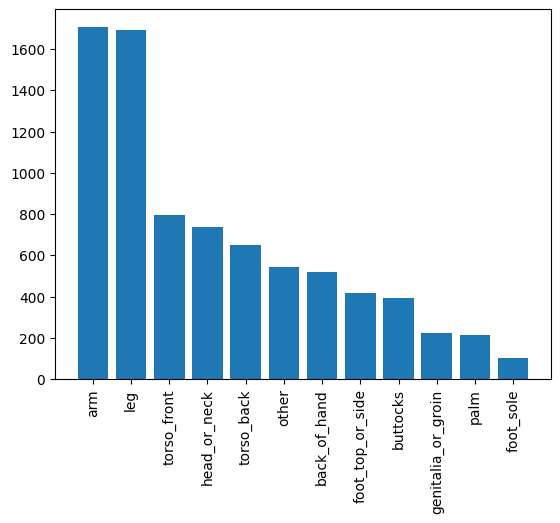

In [ ]:
#@title Display body part distribution

def get_distribution_columns(df, prefix):
  cols = [c for c in df.columns if c.startswith(prefix)]
  dist = collections.Counter()
  for c in cols:
    name = c[len(prefix):]
    val = sum(df[c] == "YES")
    dist[name] = val
  return dist

def get_distribution_and_display(df, prefix):
  ctr = get_distribution_columns(df, prefix)
  dist = dict(ctr.most_common())
  print(f'Distribution data: {dist}')
  names = list(dist.keys())
  counts = list(dist.values())
  plt.bar(names, counts)
  plt.xticks(rotation=90)  # Rotate labels by 90 degrees
  plt.show()

# Distribution data: {'arm': 1707, 'leg': 1694, 'torso_front': 795, 'head_or_neck': 737, 'torso_back': 652, 'other': 543, 'back_of_hand': 521, 'foot_top_or_side': 415, 'buttocks': 391, 'genitalia_or_groin': 222, 'palm': 215, 'foot_sole': 104}
get_distribution_and_display(Globals.cases_and_labels_df, "body_parts_")


Distribution data: {'raised_or_bumpy': 2915, 'rough_or_flaky': 1032, 'flat': 822, 'fluid_filled': 629}


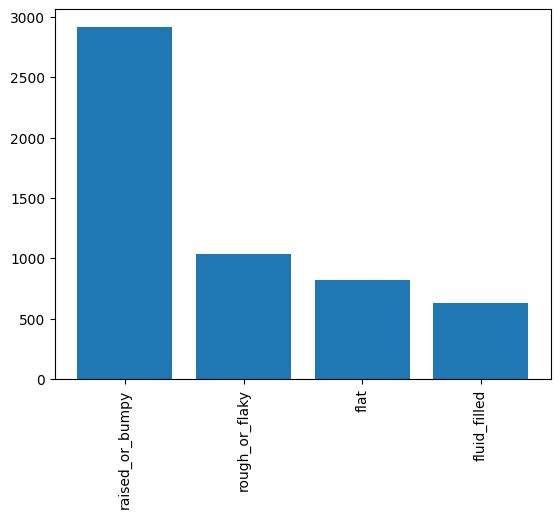

In [ ]:
#@title Display texture distribution
get_distribution_and_display(Globals.cases_and_labels_df, "textures_")

Distribution data: {'itching': 2712, 'bothersome_appearance': 1530, 'increasing_size': 1013, 'burning': 988, 'pain': 734, 'darkening': 385, 'no_relevant_experience': 308, 'bleeding': 225}


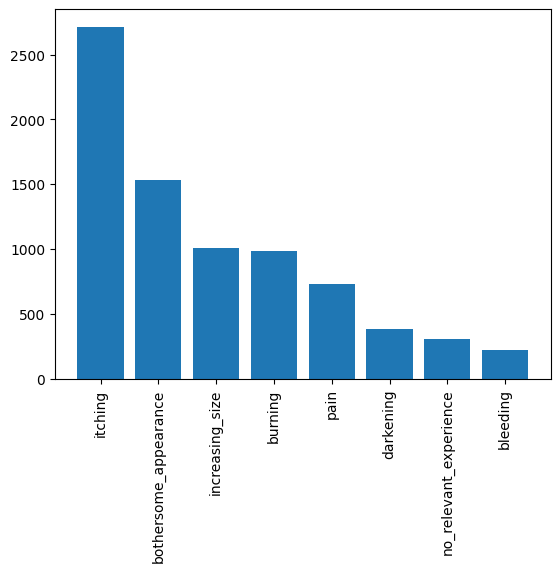

In [ ]:
#@title Display condition symptom dist
get_distribution_and_display(Globals.cases_and_labels_df, "condition_symptoms_")

Distribution data: {'no_relevant_symptoms': 2841, 'fatigue': 415, 'joint_pain': 300, 'shortness_of_breath': 139, 'chills': 120, 'mouth_sores': 96, 'fever': 90}


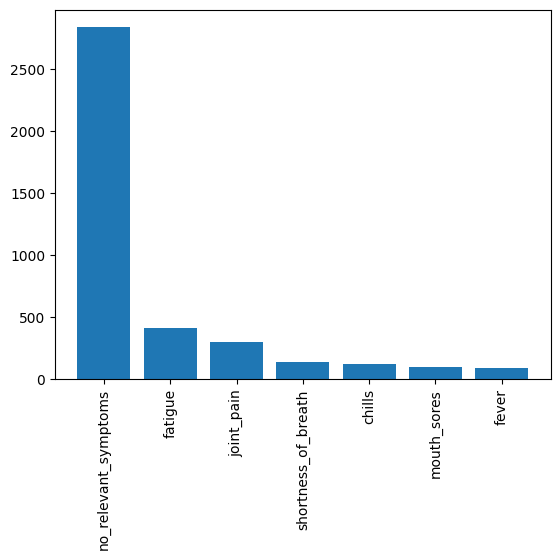

In [ ]:
#@title Display other symptoms distribution
get_distribution_and_display(Globals.cases_and_labels_df, "other_symptoms_")

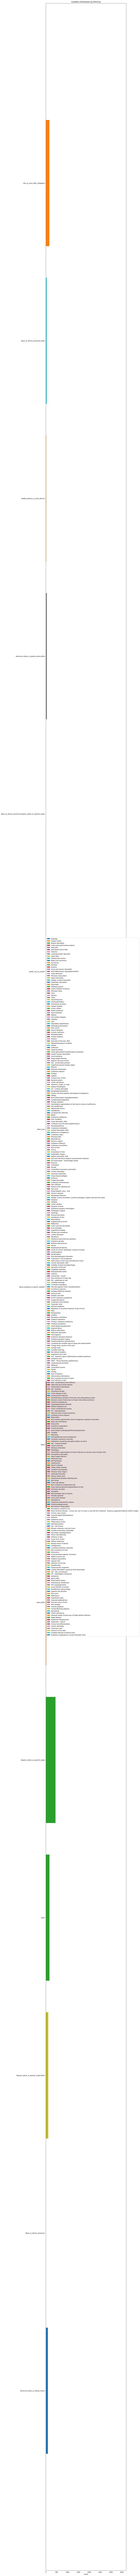

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import collections

def plot_condition_distribution(df):
    condition_ctr = collections.Counter()
    ethnicity_condition_ctr = collections.defaultdict(lambda: collections.Counter())

    # Drop rows with empty string values in the ethnicity column
    df = df[df['combined_race_ethnicity'] != ""]

    for entry in df[Globals.skin_condition_label].dropna():
        condition_ctr.update(eval(entry))
    for entry in df[Globals.weighted_skin_condition_label].dropna():
        condition_ctr.update(eval(entry).keys())

    for condition in condition_ctr:
        for ethnicity in df['combined_race_ethnicity']:
            if condition in eval(df[df['combined_race_ethnicity']==ethnicity][Globals.skin_condition_label].iloc[0]):
                ethnicity_condition_ctr[ethnicity][condition] += 1
            if condition in eval(df[df['combined_race_ethnicity']==ethnicity][Globals.weighted_skin_condition_label].iloc[0]).keys():
                ethnicity_condition_ctr[ethnicity][condition] += 1

    unique_conditions = list(condition_ctr.keys())
    unique_ethnicities = list(set(df['combined_race_ethnicity']))

    fig, ax = plt.subplots(figsize=(10, len(unique_conditions)))

    for i, condition in enumerate(unique_conditions):
        counts = [ethnicity_condition_ctr[ethnicity][condition] for ethnicity in unique_ethnicities]
        ax.barh(unique_ethnicities, counts, align='center', label=condition)
        ax.set_yticks(unique_ethnicities)
        ax.set_xlabel('Count')
        ax.set_title('Condition Distribution by Ethnicity')

    plt.legend()
    plt.show()

plot_condition_distribution(Globals.cases_and_labels_df)

